# Beach Crowd Detection - Adaptive Gamma Edition

This notebook provides beach crowd detection using adaptive gamma correction that normalizes brightness across varying lighting conditions.

**How adaptive gamma works:**
```
target_brightness = 160 (default)
current_brightness = median(grayscale_image)
gamma = log(target/255) / log(current/255)
```

## 1. Import Libraries

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage.measure import shannon_entropy
import os
from pathlib import Path
import warnings
from IPython.display import display, clear_output, HTML
import ipywidgets as widgets
from ipywidgets import interactive
import json

warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.max_open_warning'] = 0

print("✓ Libraries loaded successfully")

✓ Libraries loaded successfully


## 2. Utility Functions

In [2]:
def adjust_gamma(image, gamma=None, target_brightness=160.0):
    """Apply gamma correction - adaptive if gamma is None."""
    if gamma is not None:
        img = image.astype(np.float32) / 255.0
        img = np.power(img, gamma)
        return np.clip(img * 255.0, 0, 255).astype(np.uint8)
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if len(image.shape) == 3 else image
    current_brightness = np.clip(np.percentile(gray, 50), 1, 254)
    target_brightness = np.clip(target_brightness, 1, 254)
    
    calculated_gamma = np.log(target_brightness / 255.0) / np.log(current_brightness / 255.0)
    calculated_gamma = np.clip(calculated_gamma, 0.2, 3.0)
    
    img = image.astype(np.float32) / 255.0
    img = np.power(img, calculated_gamma)
    corrected = np.clip(img * 255.0, 0, 255).astype(np.uint8)
    
    return corrected, calculated_gamma


def calculate_mae(detected_count, ground_truth_count):
    return abs(detected_count - ground_truth_count)


def calculate_image_statistics(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if len(image.shape) == 3 else image
    return {
        'mean': np.mean(gray),
        'std': np.std(gray),
        'min': np.min(gray),
        'max': np.max(gray),
        'median': np.median(gray),
        'entropy': shannon_entropy(gray),
        'contrast': np.max(gray) - np.min(gray),
        'brightness_category': 'Dark' if np.mean(gray) < 85 else 'Medium' if np.mean(gray) < 170 else 'Bright',
        'contrast_category': 'Low' if (np.max(gray) - np.min(gray)) < 100 else 'Medium' if (np.max(gray) - np.min(gray)) < 180 else 'High'
    }


LIMIT_POLYGON = None

def load_limit_polygon(json_path):
    with open(json_path, "r") as f:
        data = json.load(f)
    first_item = next(iter(data.values()))
    regions = first_item["regions"]
    first_region = regions[next(iter(regions))]
    shape = first_region["shape_attributes"]
    return np.array(list(zip(shape["all_points_x"], shape["all_points_y"])), dtype=np.int32)


LIMIT_POLYGON = load_limit_polygon("limit_coordinates.json")

def apply_limit_mask(image, polygon=LIMIT_POLYGON):
    if polygon is None:
        return image
    h, w = image.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.fillPoly(mask, [polygon], 255)
    return cv2.bitwise_and(image, image, mask=mask)


print("✓ Utility functions loaded")

✓ Utility functions loaded


## 3. Analytical Functions

In [3]:
def analyze_color_spaces(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    return {
        'rgb': {'means': [np.mean(image[:,:,i]) for i in range(3)], 'stds': [np.std(image[:,:,i]) for i in range(3)]},
        'hsv': {'means': [np.mean(hsv[:,:,i]) for i in range(3)], 'stds': [np.std(hsv[:,:,i]) for i in range(3)]},
        'lab': {'means': [np.mean(lab[:,:,i]) for i in range(3)], 'stds': [np.std(lab[:,:,i]) for i in range(3)]}
    }


print("✓ Analytical functions loaded")

✓ Analytical functions loaded


## 4. Pipeline Processing Functions

In [4]:
def load_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not load image: {image_path}")
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


def apply_clahe(image, clip_limit=2.0):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8, 8))
    clahe_gray = clahe.apply(gray)
    return cv2.cvtColor(clahe_gray, cv2.COLOR_GRAY2RGB), clahe_gray


def apply_preprocessing(image, target_brightness=160.0, gamma=None, gaussian_size=5,
                        top_mask_percent=0.40, hsv_s_max=50, hsv_v_min=100,
                        morph_size=5, adaptive_block_size=11, adaptive_c=2):
    top_masked = apply_limit_mask(image)
    
    gamma_result = adjust_gamma(top_masked, gamma=gamma, target_brightness=target_brightness)
    if isinstance(gamma_result, tuple):
        gamma_img, gamma_used = gamma_result
    else:
        gamma_img = gamma_result
        gamma_used = gamma if gamma is not None else "N/A"

    blurred = cv2.GaussianBlur(gamma_img, (gaussian_size, gaussian_size), 0) if gaussian_size > 0 else gamma_img.copy()

    hsv = cv2.cvtColor(blurred, cv2.COLOR_RGB2HSV)
    mask_sand = (hsv[:, :, 1] < hsv_s_max) & (hsv[:, :, 2] > hsv_v_min)

    sand_mask_vis = np.zeros_like(blurred)
    sand_mask_vis[mask_sand] = blurred[mask_sand]

    non_sand_mask_vis = np.zeros_like(blurred)
    non_sand_mask_vis[~mask_sand] = blurred[~mask_sand]

    non_sand_only = blurred.copy()
    non_sand_only[mask_sand] = [0, 0, 0]

    gray = cv2.cvtColor(non_sand_only, cv2.COLOR_RGB2GRAY)

    kernel = np.ones((morph_size, morph_size), np.uint8)
    opened = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)
    morph = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)

    hsv_filtered = blurred.copy()
    hsv_filtered[~mask_sand] = [0, 0, 0]

    binary = cv2.adaptiveThreshold(morph, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                    cv2.THRESH_BINARY, adaptive_block_size, adaptive_c)

    return {
        "gamma": gamma_img, "gamma_value": gamma_used, "blurred": blurred,
        "masked": top_masked, "sand_mask": sand_mask_vis, "non_sand_mask": non_sand_mask_vis,
        "hsv_filtered": hsv_filtered, "gray": gray, "opened": opened, "morph": morph, "binary": binary
    }


def detect_blobs(binary_image, min_area=300, max_area=4500, 
                 min_circularity=0.2, min_convexity=0.5, min_inertia=0.1):
    params = cv2.SimpleBlobDetector_Params()
    params.filterByArea = True
    params.minArea = min_area
    params.maxArea = max_area
    params.filterByCircularity = True
    params.minCircularity = min_circularity
    params.filterByConvexity = True
    params.minConvexity = min_convexity
    params.filterByInertia = True
    params.minInertiaRatio = min_inertia
    params.filterByColor = False
    
    detector = cv2.SimpleBlobDetector_create(params)
    keypoints = detector.detect(binary_image)
    detected_points = np.array([[kp.pt[0], kp.pt[1]] for kp in keypoints])
    
    return keypoints, detected_points


print("✓ Processing functions loaded")

✓ Processing functions loaded


## 5. Visualization Functions

In [5]:
def visualize_pipeline(original, steps, keypoints, ground_truth_points, 
                       detected_count, gt_count, mae, blob_params):
    fig = plt.figure(figsize=(22, 14))
    gs = fig.add_gridspec(3, 4, hspace=0.35, wspace=0.3)
    
    # Row 1
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(original)
    ax1.set_title('1. Original', fontweight='bold', fontsize=10)
    ax1.axis('off')
    
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(steps['gamma'])
    gamma_val = steps.get('gamma_value', 'N/A')
    gamma_title = f'2. Gamma (γ={gamma_val:.3f})' if isinstance(gamma_val, float) else '2. Gamma'
    ax2.set_title(gamma_title, fontweight='bold', fontsize=10)
    ax2.axis('off')
    
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.imshow(steps['blurred'])
    ax3.set_title('3. Blur', fontweight='bold', fontsize=10)
    ax3.axis('off')
    
    ax4 = fig.add_subplot(gs[0, 3])
    ax4.imshow(steps['masked'])
    ax4.set_title('4. Masked Region', fontweight='bold', fontsize=10)
    ax4.axis('off')
    
    # Row 2
    ax5 = fig.add_subplot(gs[1, 0])
    ax5.imshow(steps['sand_mask'])
    ax5.set_title('5. Sand Mask', fontweight='bold', fontsize=10)
    ax5.axis('off')
    
    ax6 = fig.add_subplot(gs[1, 1])
    ax6.imshow(steps['non_sand_mask'])
    ax6.set_title('6. Non-Sand', fontweight='bold', fontsize=10)
    ax6.axis('off')
    
    ax7 = fig.add_subplot(gs[1, 2])
    ax7.imshow(steps['gray'], cmap='gray')
    ax7.set_title('7. Grayscale', fontweight='bold', fontsize=10)
    ax7.axis('off')
    
    ax8 = fig.add_subplot(gs[1, 3])
    ax8.imshow(steps['morph'], cmap='gray')
    ax8.set_title('8. Morphology', fontweight='bold', fontsize=10)
    ax8.axis('off')
    
    # Row 3
    ax9 = fig.add_subplot(gs[2, 0])
    ax9.imshow(steps['binary'], cmap='gray')
    ax9.set_title('9. Binary (Adaptive)', fontweight='bold', fontsize=10, color='blue')
    ax9.axis('off')
    
    # Detection results
    ax10 = fig.add_subplot(gs[2, 1:3])
    result_img = original.copy()
    
    if len(keypoints) > 0:
        for kp in keypoints:
            x, y = int(kp.pt[0]), int(kp.pt[1])
            cv2.circle(result_img, (x, y), 8, (0, 255, 0), 2)
    
    if len(ground_truth_points) > 0:
        for pt in ground_truth_points:
            x, y = int(pt[0]), int(pt[1])
            cv2.circle(result_img, (x, y), 12, (255, 0, 0), 2)
    
    ax10.imshow(result_img)
    ax10.set_title('10. Detection Results', fontweight='bold', fontsize=11)
    ax10.axis('off')
    
    red_patch = mpatches.Patch(color='red', label=f'GT: {gt_count}')
    green_patch = mpatches.Patch(color='green', label=f'Det: {detected_count}')
    ax10.legend(handles=[red_patch, green_patch], loc='upper right')
    
    # Stats
    ax11 = fig.add_subplot(gs[2, 3])
    ax11.axis('off')
    
    stats_text = f"""
    RESULTS
    {'=' * 25}
    
    GT: {gt_count}
    Detected: {detected_count}
    MAE: {mae}
    Error: {(mae/gt_count*100) if gt_count > 0 else 0:.1f}%
    
    BLOB PARAMS
    {'=' * 25}
    
    Area: {blob_params['min_area']}-{blob_params['max_area']}
    Circ: {blob_params['min_circularity']:.2f}
    Conv: {blob_params['min_convexity']:.2f}
    Inert: {blob_params['min_inertia']:.2f}
    """
    
    ax11.text(0.05, 0.5, stats_text, fontsize=9, family='monospace',
              verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.show()


print("✓ Visualization functions loaded")

✓ Visualization functions loaded


## 6. Load Ground Truth & Configuration

In [6]:
def load_annotations(annotations_path):
    if not os.path.exists(annotations_path):
        print(f"⚠ Annotations file not found: {annotations_path}")
        return pd.DataFrame()
    
    for sep in [';', ',', '\t']:
        try:
            df = pd.read_csv(annotations_path, sep=sep)
            if 'file' in df.columns and 'x' in df.columns and 'y' in df.columns:
                print(f"✓ Loaded {len(df)} annotations")
                return df
        except:
            continue
    
    print(f"⚠ Could not parse annotations file")
    return pd.DataFrame()


def get_ground_truth(annotations_df, image_name):
    if annotations_df.empty:
        return np.array([])
    
    matches = annotations_df[
        (annotations_df['file'] == image_name) |
        (annotations_df['file'] == f"{image_name}.jpg") |
        (annotations_df['file'] == f"{image_name}.png")
    ]
    
    if len(matches) > 0:
        return matches[['x', 'y']].values
    return np.array([])


# Configuration
IMAGES_DIR = 'images'
ANNOTATIONS_PATH = 'coordinates_human_annotated.csv'

annotations_df = load_annotations(ANNOTATIONS_PATH)

if os.path.exists(IMAGES_DIR):
    image_files = sorted([f for f in os.listdir(IMAGES_DIR) 
                         if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    print(f"✓ Found {len(image_files)} images")
else:
    print(f"⚠ Images directory not found: {IMAGES_DIR}")
    image_files = []

✓ Loaded 705 annotations
✓ Found 10 images


## 7. Comprehensive Analysis Function

In [7]:
def comprehensive_analysis(image_file, clahe_clip, gaussian_size, adaptive_block_size,
                           adaptive_c, top_mask_percent, hsv_s_max, hsv_v_min,
                           morph_size, min_area, max_area, min_circularity,
                           min_convexity, min_inertia, target_brightness=160.0, clear=False):
    if clear:
        clear_output(wait=True)

    image_path = os.path.join(IMAGES_DIR, image_file)
    original = load_image(image_path)
    image_name = Path(image_file).stem

    display(HTML(f"""
    <div style="background-color: #2c3e50; color: white; padding: 20px; border-radius: 10px; margin-bottom: 20px;">
        <h1 style="margin: 0;">📊 Beach Crowd Detection</h1>
        <h2 style="margin: 10px 0 0 0; color: #3498db;">{image_file}</h2>
    </div>
    """))

    stats = calculate_image_statistics(original)
    color_analysis = analyze_color_spaces(original)

    display(HTML("""
    <div style="background-color: #27ae60; color: white; padding: 12px; border-radius: 5px; margin: 20px 0 10px 0;">
        <h2 style="margin: 0;">⚙️ Detection Pipeline</h2>
    </div>
    """))

    ground_truth_points = get_ground_truth(annotations_df, image_name)
    gt_count = len(ground_truth_points)

    clahe_rgb, _ = apply_clahe(original, clahe_clip)

    steps = apply_preprocessing(
        clahe_rgb,
        target_brightness=target_brightness,
        gaussian_size=gaussian_size,
        top_mask_percent=top_mask_percent,
        hsv_s_max=hsv_s_max,
        hsv_v_min=hsv_v_min,
        morph_size=morph_size,
        adaptive_block_size=adaptive_block_size,
        adaptive_c=adaptive_c,
    )

    keypoints, detected_points = detect_blobs(
        steps['binary'],
        min_area=min_area,
        max_area=max_area,
        min_circularity=min_circularity,
        min_convexity=min_convexity,
        min_inertia=min_inertia,
    )
    detected_count = len(keypoints)

    mae = calculate_mae(detected_count, gt_count)
    squared_error = (detected_count - gt_count) ** 2
    error_percent = (mae / gt_count * 100) if gt_count > 0 else 0.0

    blob_params = {
        "min_area": min_area, "max_area": max_area,
        "min_circularity": min_circularity, "min_convexity": min_convexity, "min_inertia": min_inertia
    }

    visualize_pipeline(original, steps, keypoints, ground_truth_points,
                       detected_count, gt_count, mae, blob_params)

    display(HTML(f"""
    <div style="background-color: #f39c12; color: black; padding: 15px; border-radius: 5px; margin: 20px 0;">
        <h2 style="margin: 0 0 10px 0;">✅ Analysis Complete</h2>
        <table style="width: 100%; color: black;">
            <tr><td><b>Ground Truth:</b></td><td>{gt_count} people</td></tr>
            <tr><td><b>Detected:</b></td><td>{detected_count} people</td></tr>
            <tr><td><b>MAE:</b></td><td>{mae} ({error_percent:.1f}% error)</td></tr>
            <tr><td><b>Squared Error:</b></td><td>{squared_error}</td></tr>
        </table>
    </div>
    """))

    return {
        "image_file": image_file, "image_name": image_name,
        "ground_truth_count": gt_count, "detected_count": detected_count,
        "mae": mae, "squared_error": squared_error, "error_percent": error_percent,
        "blob_params": blob_params, "stats": stats, "color_analysis": color_analysis,
        "ground_truth_points": ground_truth_points, "detected_points": detected_points
    }

## 8. Interactive Control Panel

In [8]:
if image_files:
    style = {'description_width': '200px'}
    layout = widgets.Layout(width='550px')
    
    display(HTML("""
    <div style="background-color: #34495e; color: white; padding: 20px; border-radius: 10px; margin-bottom: 20px;">
        <h1 style="margin: 0;">🎯 Beach Crowd Detection - Interactive</h1>
        <p style="margin: 10px 0 0 0;">Real-time parameter tuning with adaptive gamma correction</p>
    </div>
    """))
    
    unified_interface = interactive(
        comprehensive_analysis,
        image_file=widgets.Dropdown(options=image_files, value=image_files[-1],
                                     description='📷 Image:', style=style, layout=layout),
        clahe_clip=widgets.FloatSlider(value=2.5, min=1.0, max=4.0, step=0.5,
                                        description='CLAHE Clip:', style=style, layout=layout, continuous_update=False),
        gaussian_size=widgets.IntSlider(value=5, min=3, max=15, step=2,
                                         description='Gaussian Size:', style=style, layout=layout, continuous_update=False),
        top_mask_percent=widgets.FloatSlider(value=0.40, min=0.0, max=0.8, step=0.05,
                                              description='Top Mask %:', style=style, layout=layout, continuous_update=False),
        hsv_s_max=widgets.IntSlider(value=35, min=20, max=120, step=5,
                                     description='HSV S Max (Sand):', style=style, layout=layout, continuous_update=False),
        hsv_v_min=widgets.IntSlider(value=180, min=80, max=220, step=5,
                                     description='HSV V Min (Sand):', style=style, layout=layout, continuous_update=False),
        morph_size=widgets.IntSlider(value=5, min=3, max=15, step=2,
                                      description='Morph Size:', style=style, layout=layout, continuous_update=False),
        adaptive_block_size=widgets.IntSlider(value=21, min=7, max=51, step=2,
                                               description='Adaptive Block:', style=style, layout=layout, continuous_update=False),
        adaptive_c=widgets.IntSlider(value=1, min=-10, max=10, step=1,
                                      description='Adaptive C:', style=style, layout=layout, continuous_update=False),
        min_area=widgets.IntSlider(value=50, min=50, max=1600, step=10,
                                    description='Blob Min Area:', style=style, layout=layout, continuous_update=False),
        max_area=widgets.IntSlider(value=2000, min=200, max=8000, step=50,
                                    description='Blob Max Area:', style=style, layout=layout, continuous_update=False),
        min_circularity=widgets.FloatSlider(value=0.20, min=0.0, max=1.0, step=0.01,
                                             description='Blob Min Circularity:', style=style, layout=layout, continuous_update=False),
        min_convexity=widgets.FloatSlider(value=0.25, min=0.0, max=1.0, step=0.01,
                                           description='Blob Min Convexity:', style=style, layout=layout, continuous_update=False),
        min_inertia=widgets.FloatSlider(value=0.10, min=0.0, max=1.0, step=0.01,
                                         description='Blob Min Inertia:', style=style, layout=layout, continuous_update=False)
    )
    
    display(unified_interface)
else:
    print("⚠ No images found.")

interactive(children=(Dropdown(description='📷 Image:', index=9, layout=Layout(width='550px'), options=('166028…

## 9. Batch Processing - All Images

In [ ]:
"""
Generate visualizations for the Beach Crowd Detection Technical Summary
Run this after the batch processing cell to create figures for the document.
"""

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# ============================================================
# FIGURE 1: Sample Pipeline Visualization (single image)
# ============================================================
def generate_pipeline_figure(image_file, results, steps_cache=None):
    """
    Generate a compact pipeline visualization for one sample image.
    Call this after running comprehensive_analysis on an image.
    """
    image_path = os.path.join(IMAGES_DIR, image_file)
    original = load_image(image_path)
    image_name = Path(image_file).stem
    
    clahe_rgb, _ = apply_clahe(original, 2.5)
    steps = apply_preprocessing(
        clahe_rgb, target_brightness=160.0, gaussian_size=5,
        top_mask_percent=0.40, hsv_s_max=35, hsv_v_min=180,
        morph_size=5, adaptive_block_size=21, adaptive_c=1
    )
    
    keypoints, _ = detect_blobs(steps['binary'], min_area=50, max_area=2000,
                                 min_circularity=0.20, min_convexity=0.25, min_inertia=0.10)
    
    ground_truth_points = get_ground_truth(annotations_df, image_name)
    
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    fig.suptitle(f'Pipeline Steps: {image_file}', fontsize=12, fontweight='bold')
    
    # Row 1: Preprocessing
    axes[0,0].imshow(original)
    axes[0,0].set_title('1. Original', fontsize=9)
    axes[0,0].axis('off')
    
    axes[0,1].imshow(steps['masked'])
    axes[0,1].set_title('2. Polygon Mask', fontsize=9)
    axes[0,1].axis('off')
    
    axes[0,2].imshow(steps['gamma'])
    axes[0,2].set_title(f'3. Adaptive γ={steps["gamma_value"]:.2f}', fontsize=9)
    axes[0,2].axis('off')
    
    axes[0,3].imshow(steps['sand_mask'])
    axes[0,3].set_title('4. Sand Mask', fontsize=9)
    axes[0,3].axis('off')
    
    # Row 2: Detection
    axes[1,0].imshow(steps['non_sand_mask'])
    axes[1,0].set_title('5. Non-Sand', fontsize=9)
    axes[1,0].axis('off')
    
    axes[1,1].imshow(steps['morph'], cmap='gray')
    axes[1,1].set_title('6. Morphology', fontsize=9)
    axes[1,1].axis('off')
    
    axes[1,2].imshow(steps['binary'], cmap='gray')
    axes[1,2].set_title('7. Binary', fontsize=9)
    axes[1,2].axis('off')
    
    # Final detection
    result_img = original.copy()
    for kp in keypoints:
        x, y = int(kp.pt[0]), int(kp.pt[1])
        cv2.circle(result_img, (x, y), 6, (0, 255, 0), 2)
    for pt in ground_truth_points:
        x, y = int(pt[0]), int(pt[1])
        cv2.circle(result_img, (x, y), 8, (255, 0, 0), 2)
    
    axes[1,3].imshow(result_img)
    axes[1,3].set_title(f'8. Result: GT={len(ground_truth_points)}, Det={len(keypoints)}', fontsize=9)
    axes[1,3].axis('off')
    
    plt.tight_layout()
    plt.savefig('pipeline_sample.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✓ Saved: pipeline_sample.png")


# ============================================================
# FIGURE 2: Results Table and Bar Chart
# ============================================================
def generate_results_figures(results):
    """
    Generate quantitative results visualization.
    Call this after the batch processing loop with the 'results' list.
    """
    if not results:
        print("No results to visualize")
        return
    
    # Extract data
    image_names = [r['image_name'] for r in results]
    gt_counts = [r['ground_truth_count'] for r in results]
    det_counts = [r['detected_count'] for r in results]
    maes = [r['mae'] for r in results]
    error_pcts = [r['error_percent'] for r in results]
    
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Left: Bar chart comparing GT vs Detected
    x = np.arange(len(image_names))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, gt_counts, width, label='Ground Truth', color='#3498db')
    bars2 = ax1.bar(x + width/2, det_counts, width, label='Detected', color='#2ecc71')
    
    ax1.set_xlabel('Image')
    ax1.set_ylabel('People Count')
    ax1.set_title('Ground Truth vs Detected Count per Image')
    ax1.set_xticks(x)
    ax1.set_xticklabels([name[:8] for name in image_names], rotation=45, ha='right', fontsize=8)
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # Right: Error percentage per image
    colors = ['#e74c3c' if e > 30 else '#f39c12' if e > 15 else '#2ecc71' for e in error_pcts]
    ax2.bar(x, error_pcts, color=colors)
    ax2.axhline(y=np.mean(error_pcts), color='red', linestyle='--', label=f'Mean: {np.mean(error_pcts):.1f}%')
    ax2.set_xlabel('Image')
    ax2.set_ylabel('Error %')
    ax2.set_title('Detection Error Percentage per Image')
    ax2.set_xticks(x)
    ax2.set_xticklabels([name[:8] for name in image_names], rotation=45, ha='right', fontsize=8)
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('results_chart.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✓ Saved: results_chart.png")
    
    # Print summary table
    print("\n" + "="*70)
    print("QUANTITATIVE RESULTS SUMMARY")
    print("="*70)
    print(f"{'Image':<15} {'GT':>6} {'Det':>6} {'MAE':>6} {'Error%':>8}")
    print("-"*70)
    for r in results:
        print(f"{r['image_name'][:15]:<15} {r['ground_truth_count']:>6} {r['detected_count']:>6} {r['mae']:>6} {r['error_percent']:>7.1f}%")
    print("-"*70)
    print(f"{'MEAN':<15} {np.mean(gt_counts):>6.1f} {np.mean(det_counts):>6.1f} {np.mean(maes):>6.1f} {np.mean(error_pcts):>7.1f}%")
    print("="*70)
    
    # Global metrics
    total_gt = sum(gt_counts)
    total_det = sum(det_counts)
    overall_mae = np.mean(maes)
    overall_mse = np.mean([r['squared_error'] for r in results])
    
    print(f"\nGLOBAL METRICS:")
    print(f"  Total Ground Truth: {total_gt} people")
    print(f"  Total Detected:     {total_det} people")
    print(f"  Mean Absolute Error (MAE): {overall_mae:.2f} people/image")
    print(f"  Mean Squared Error (MSE):  {overall_mse:.2f}")
    print(f"  Mean Error Percentage:     {np.mean(error_pcts):.1f}%")


# ============================================================
# Run after batch processing:
# ============================================================
# generate_pipeline_figure(image_files[0], results)
# generate_results_figures(results)


=== Processing: 1660284000.jpg ===


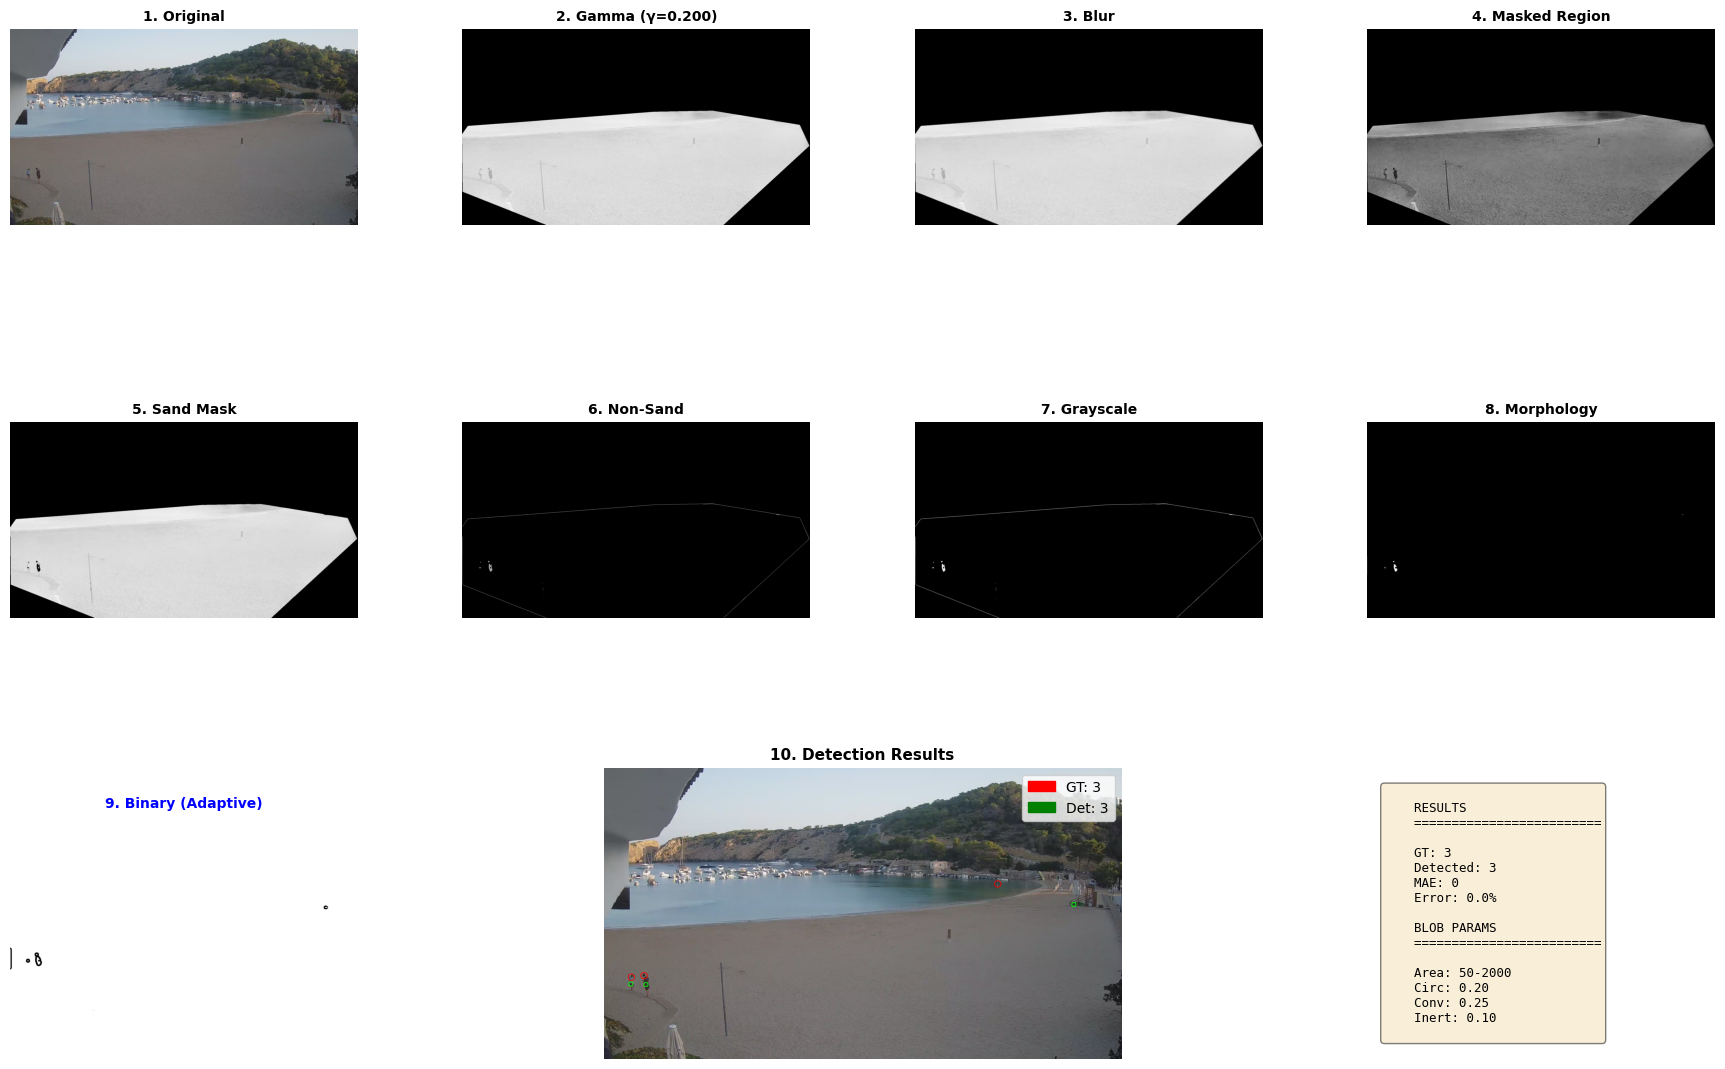


=== Processing: 1660287600.jpg ===


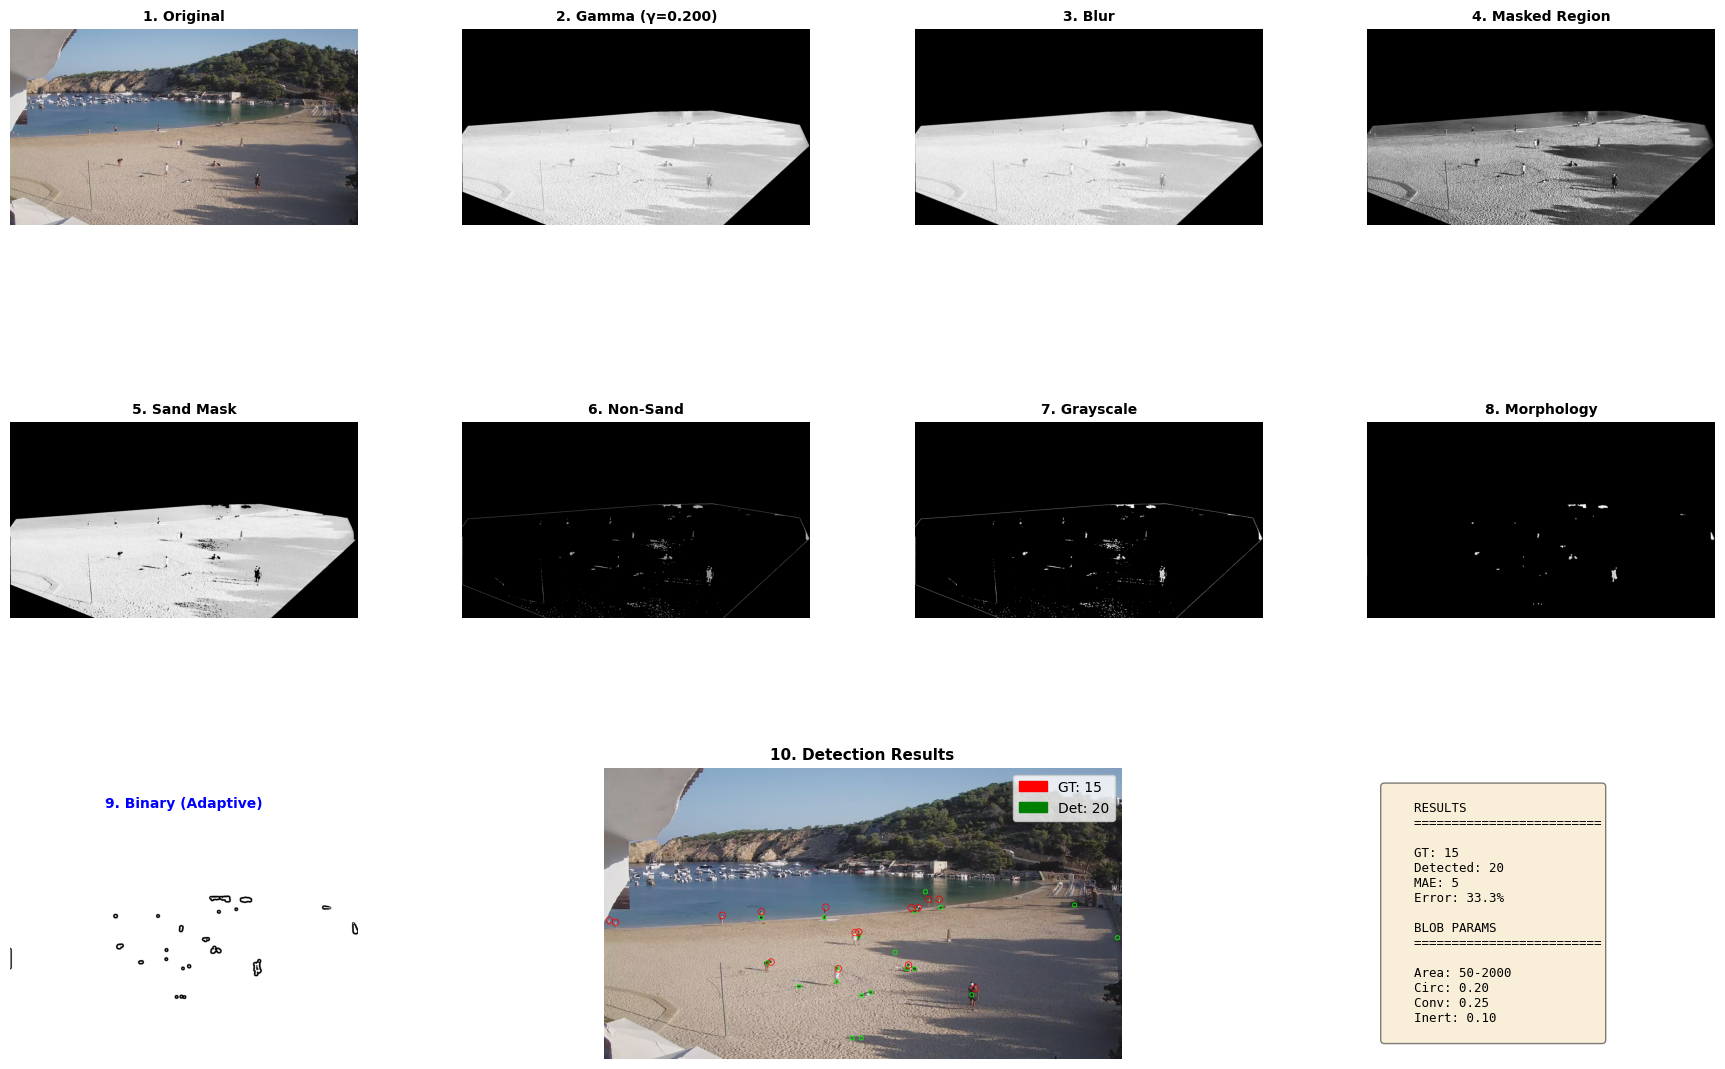


=== Processing: 1660291200.jpg ===


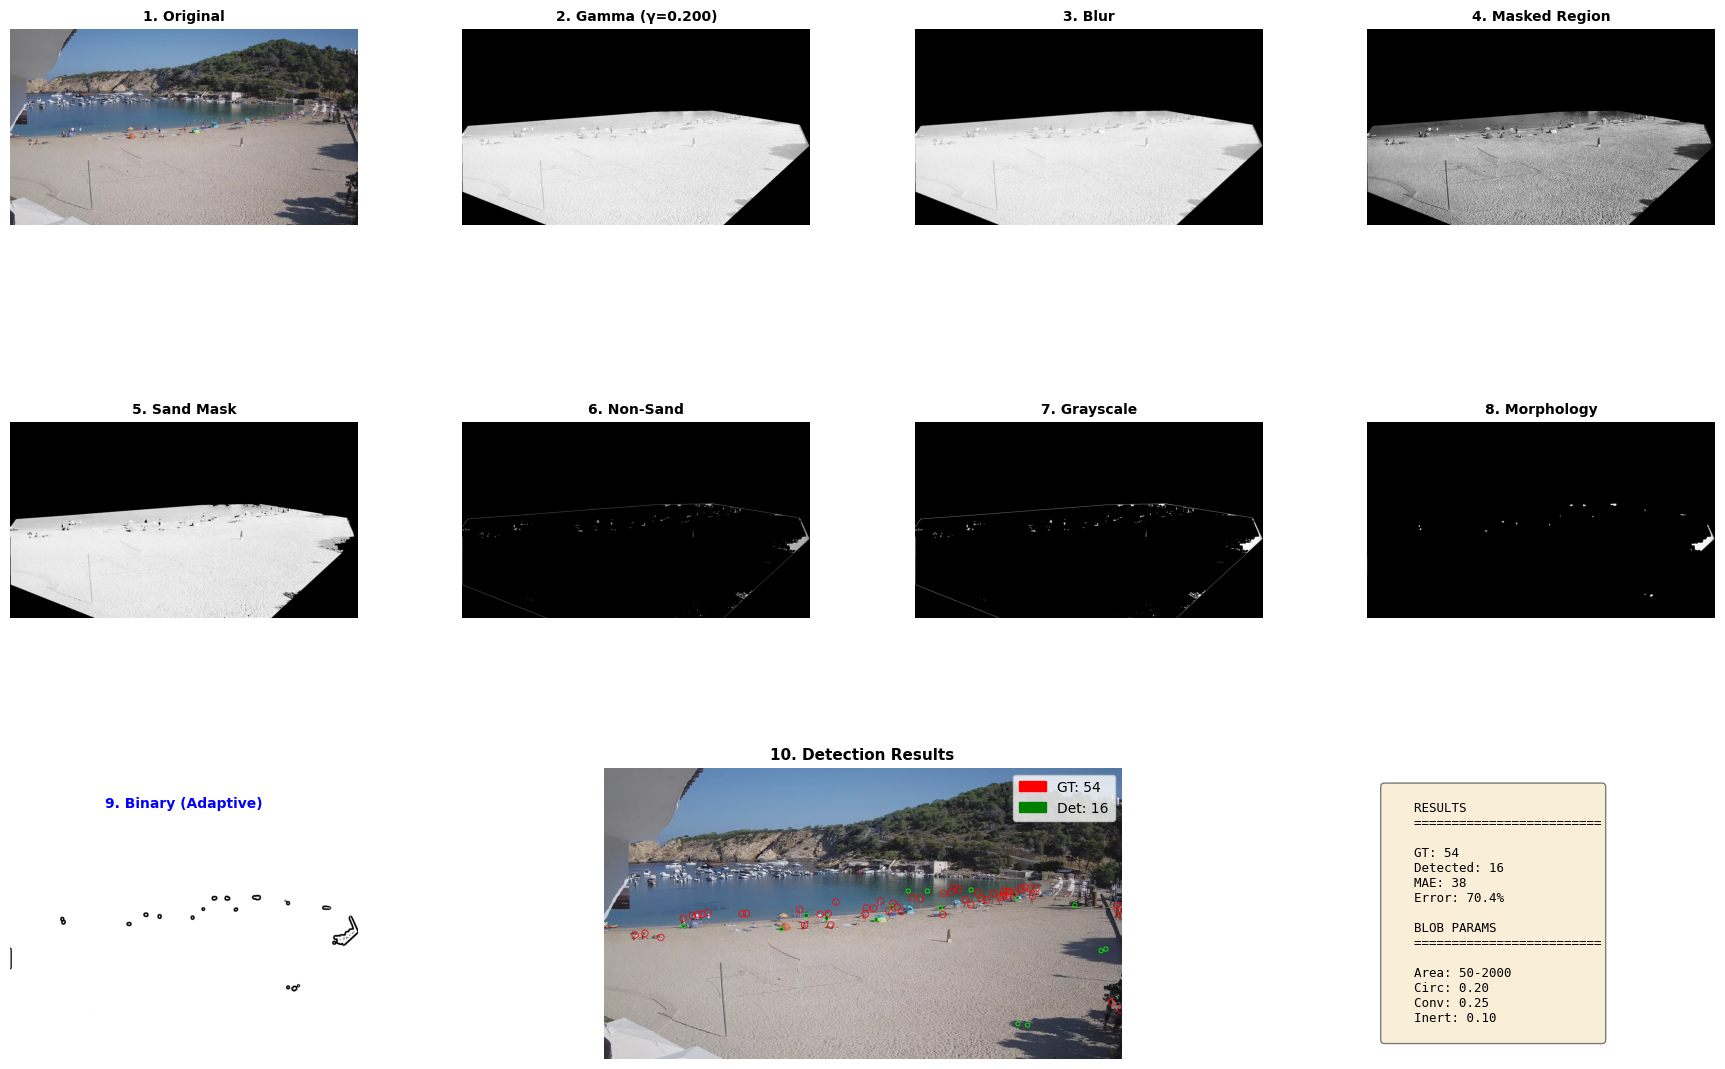


=== Processing: 1660294800.jpg ===


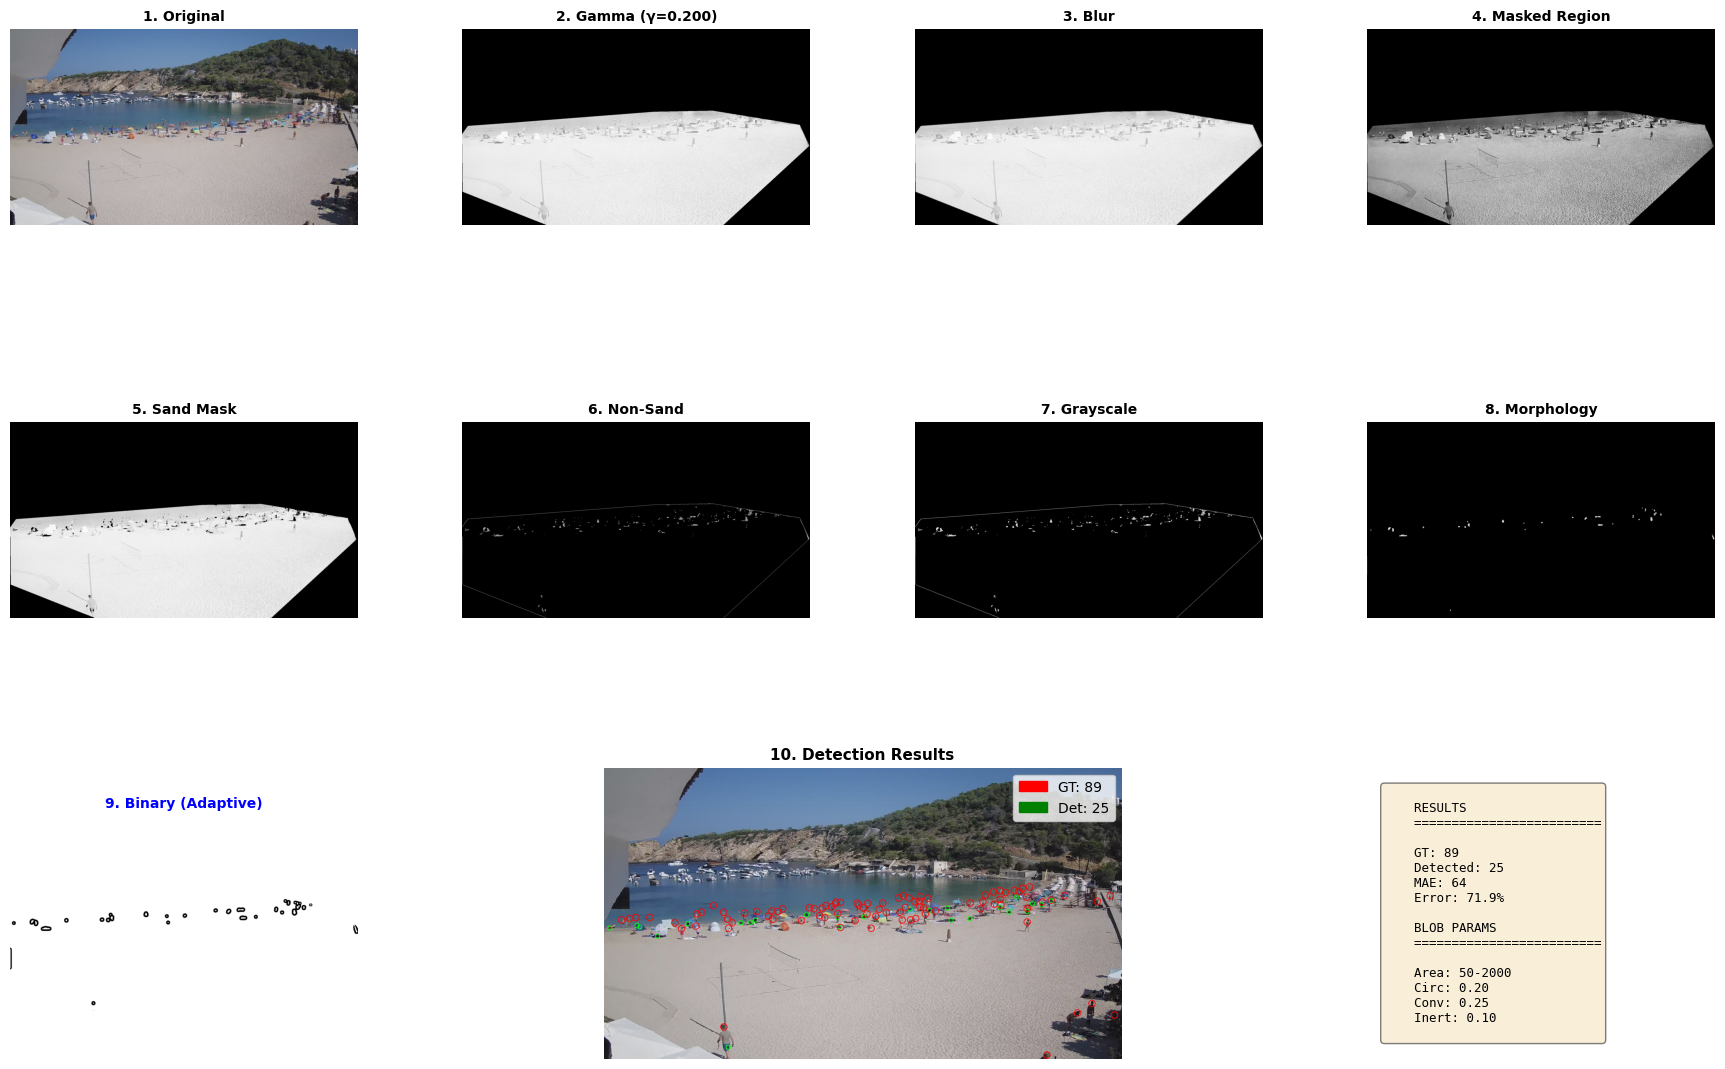


=== Processing: 1660298400.jpg ===


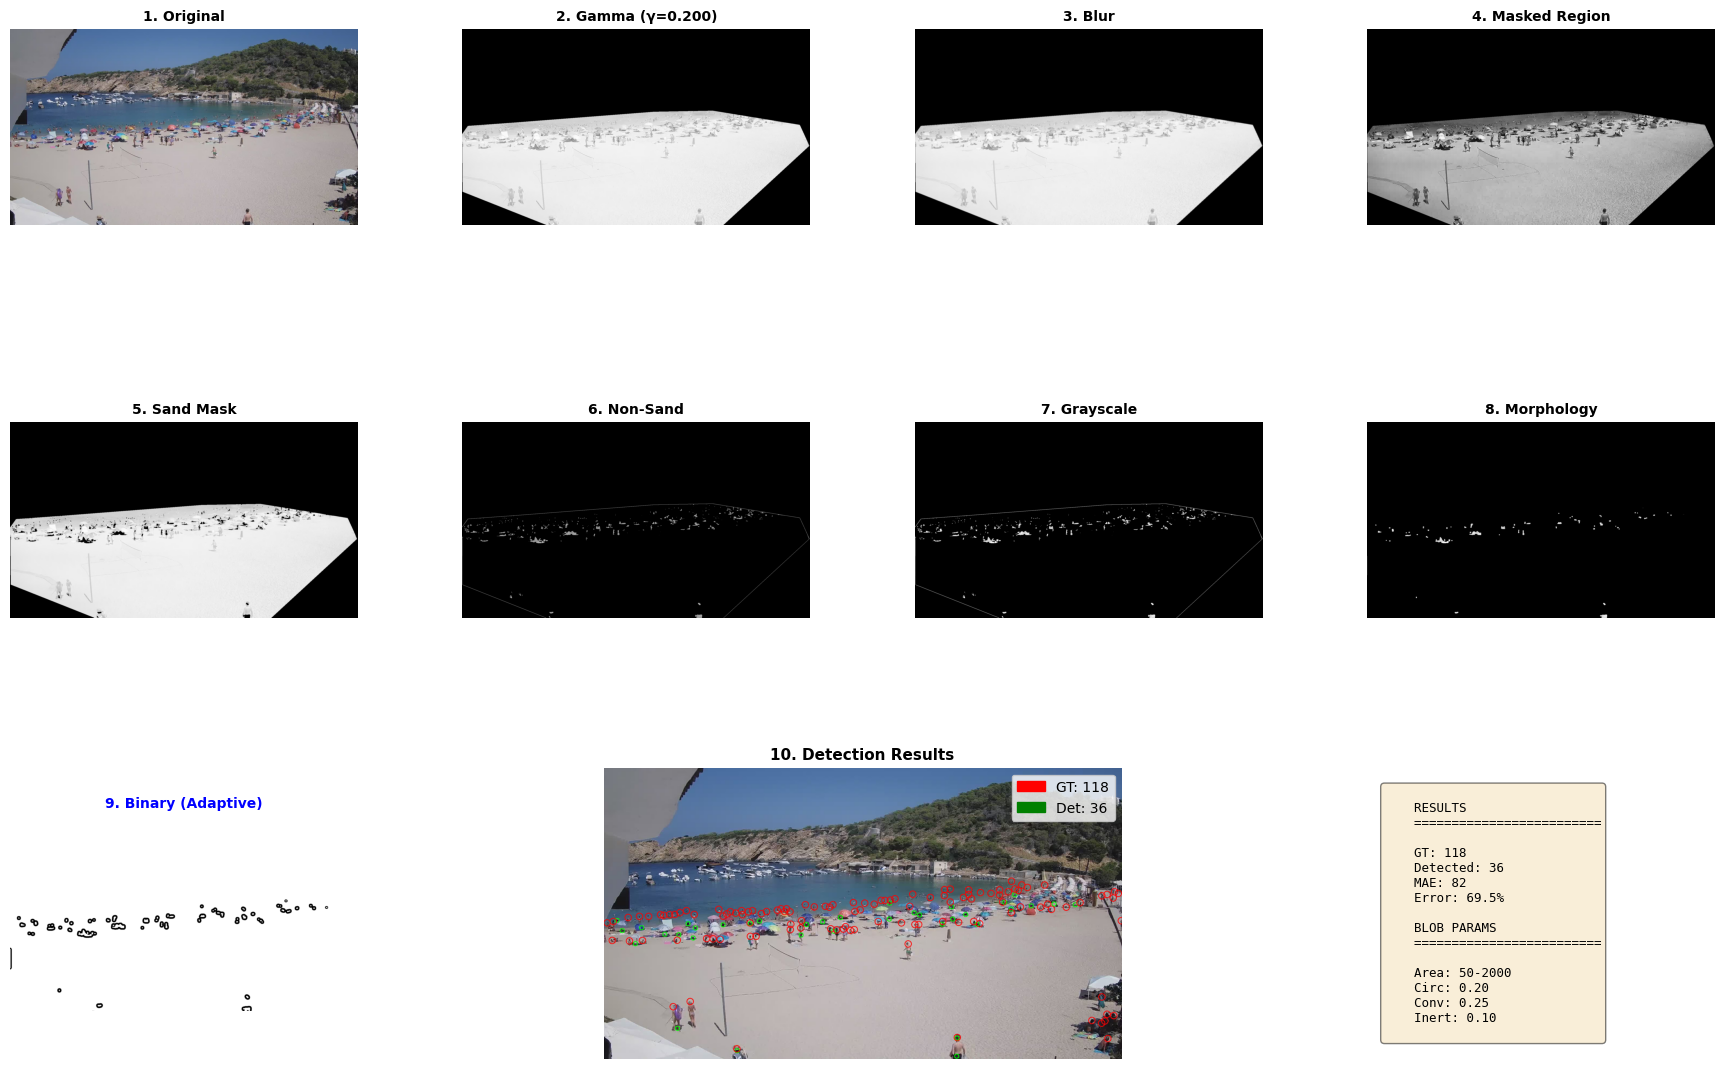


=== Processing: 1660302000.jpg ===


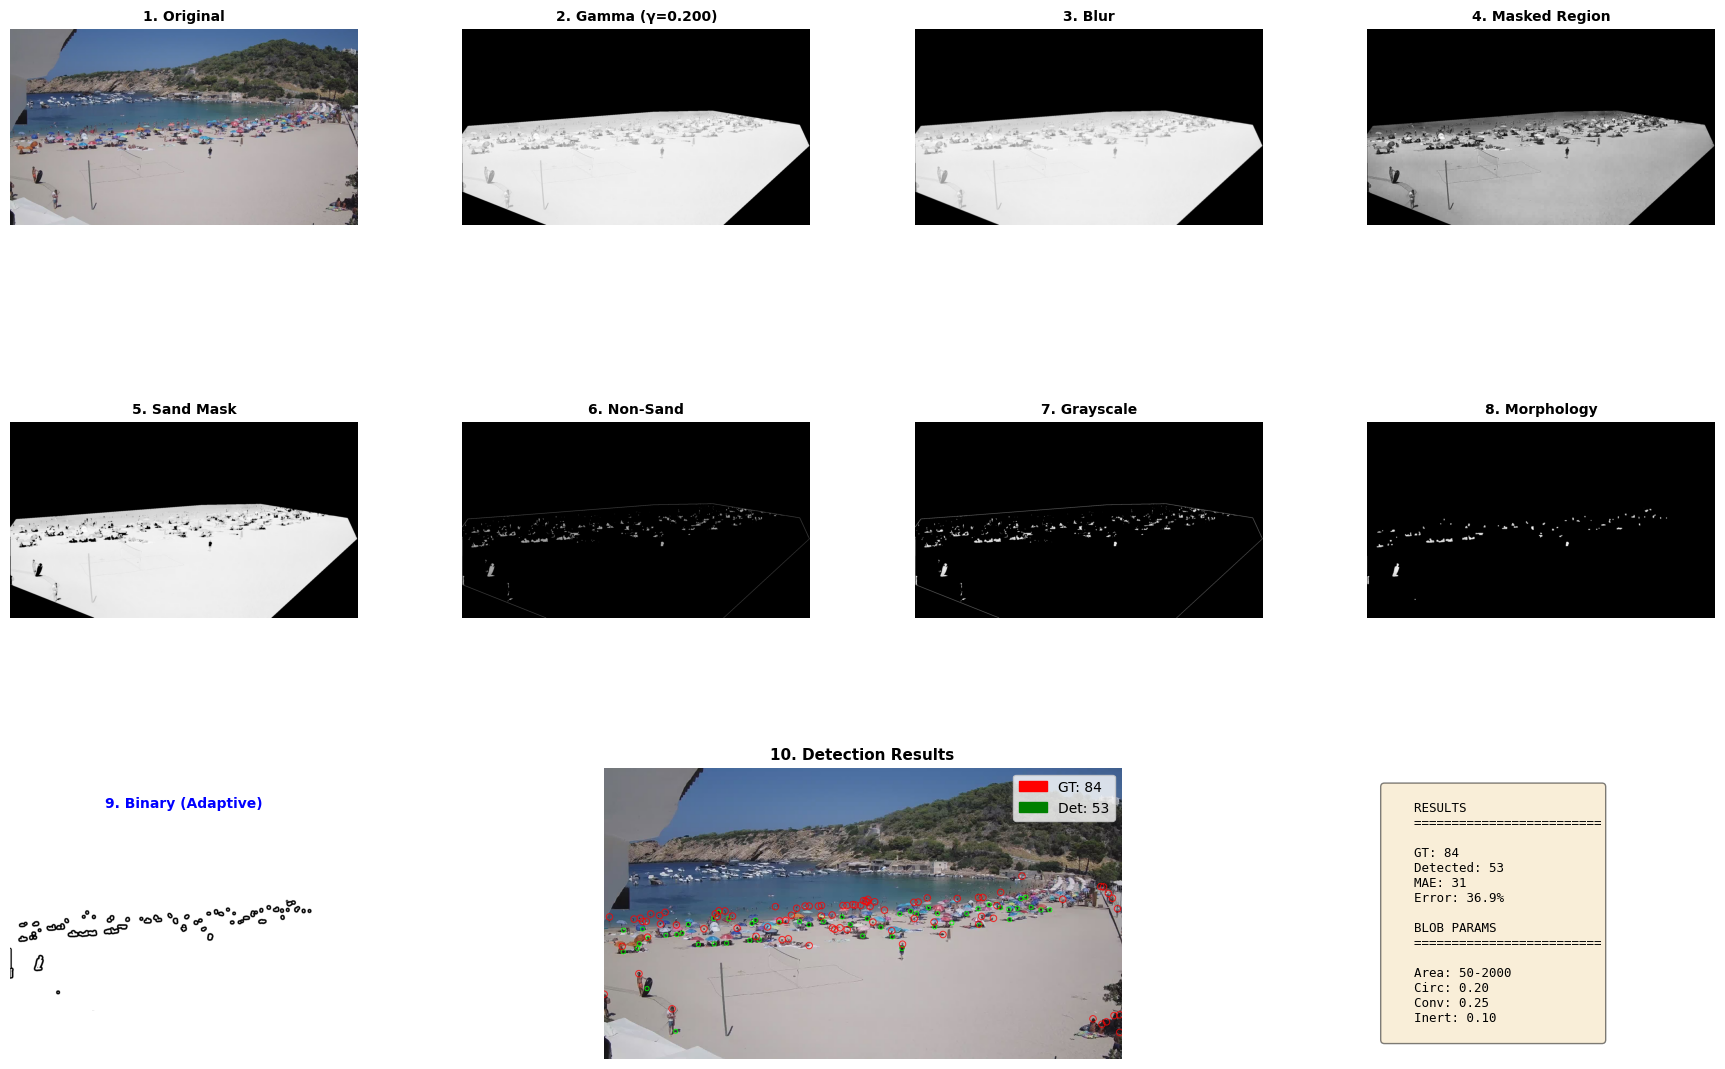


=== Processing: 1660305600.jpg ===


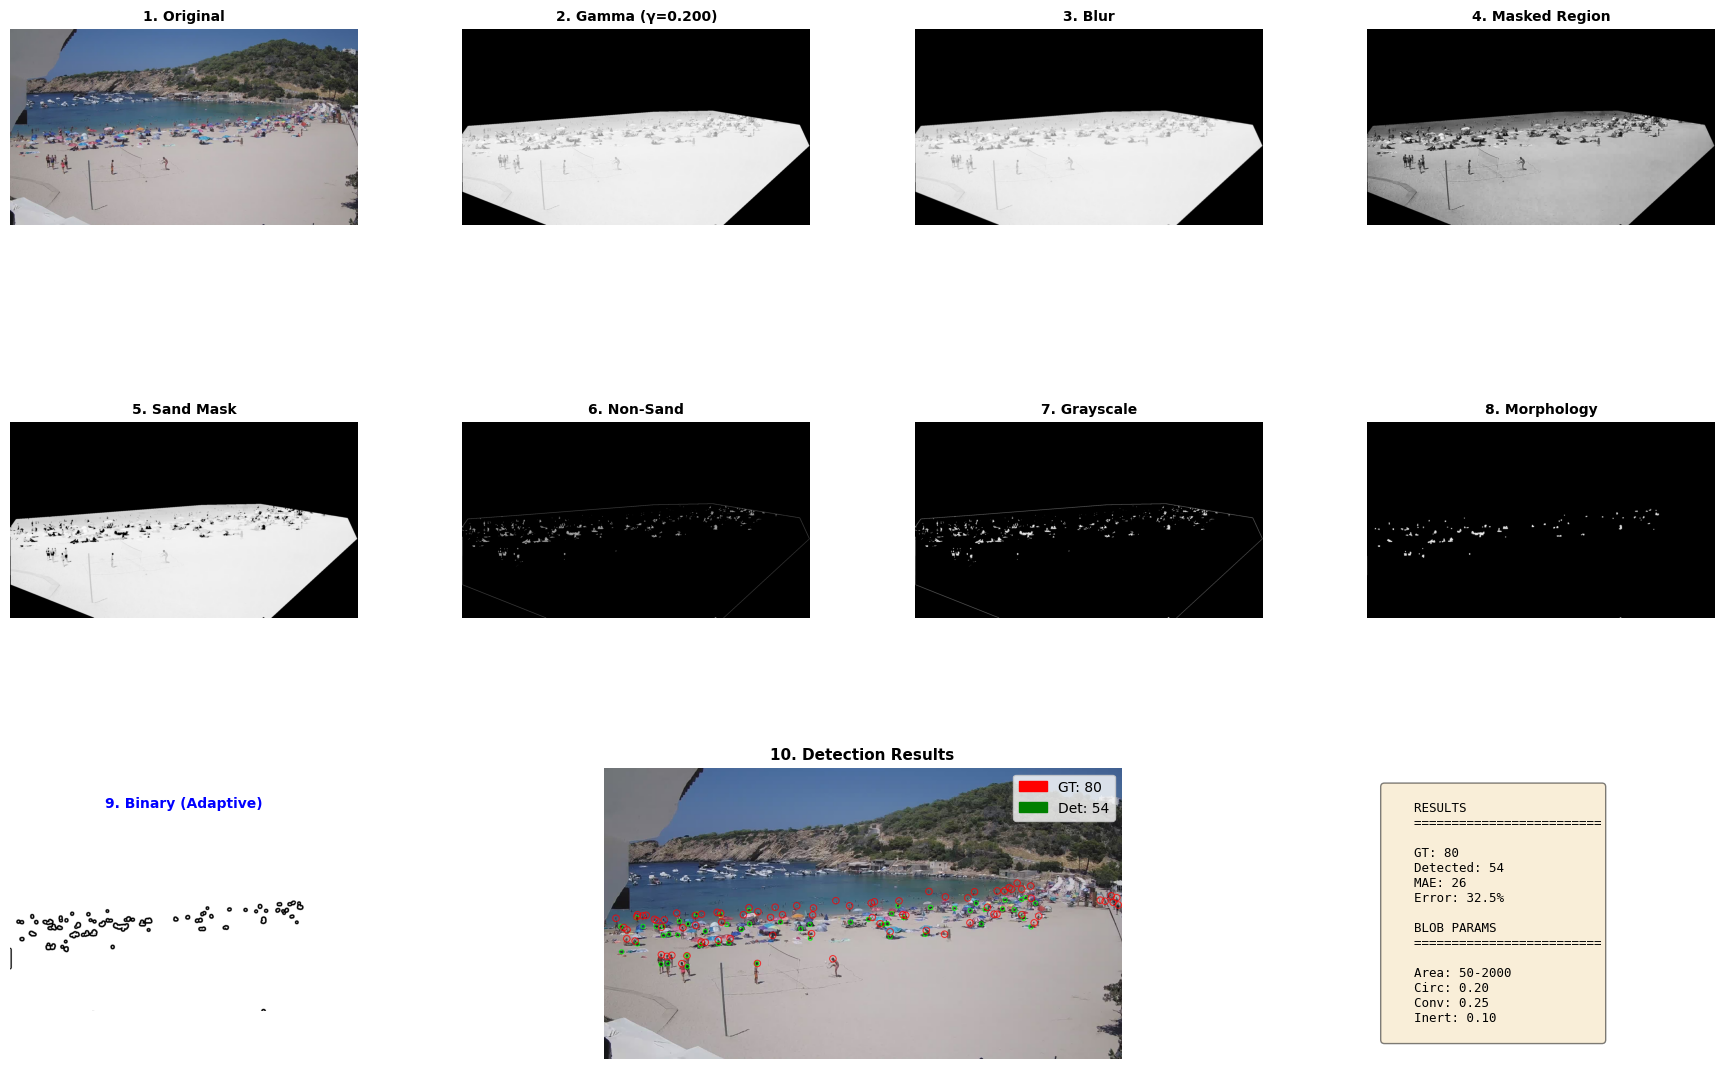


=== Processing: 1660309200.jpg ===


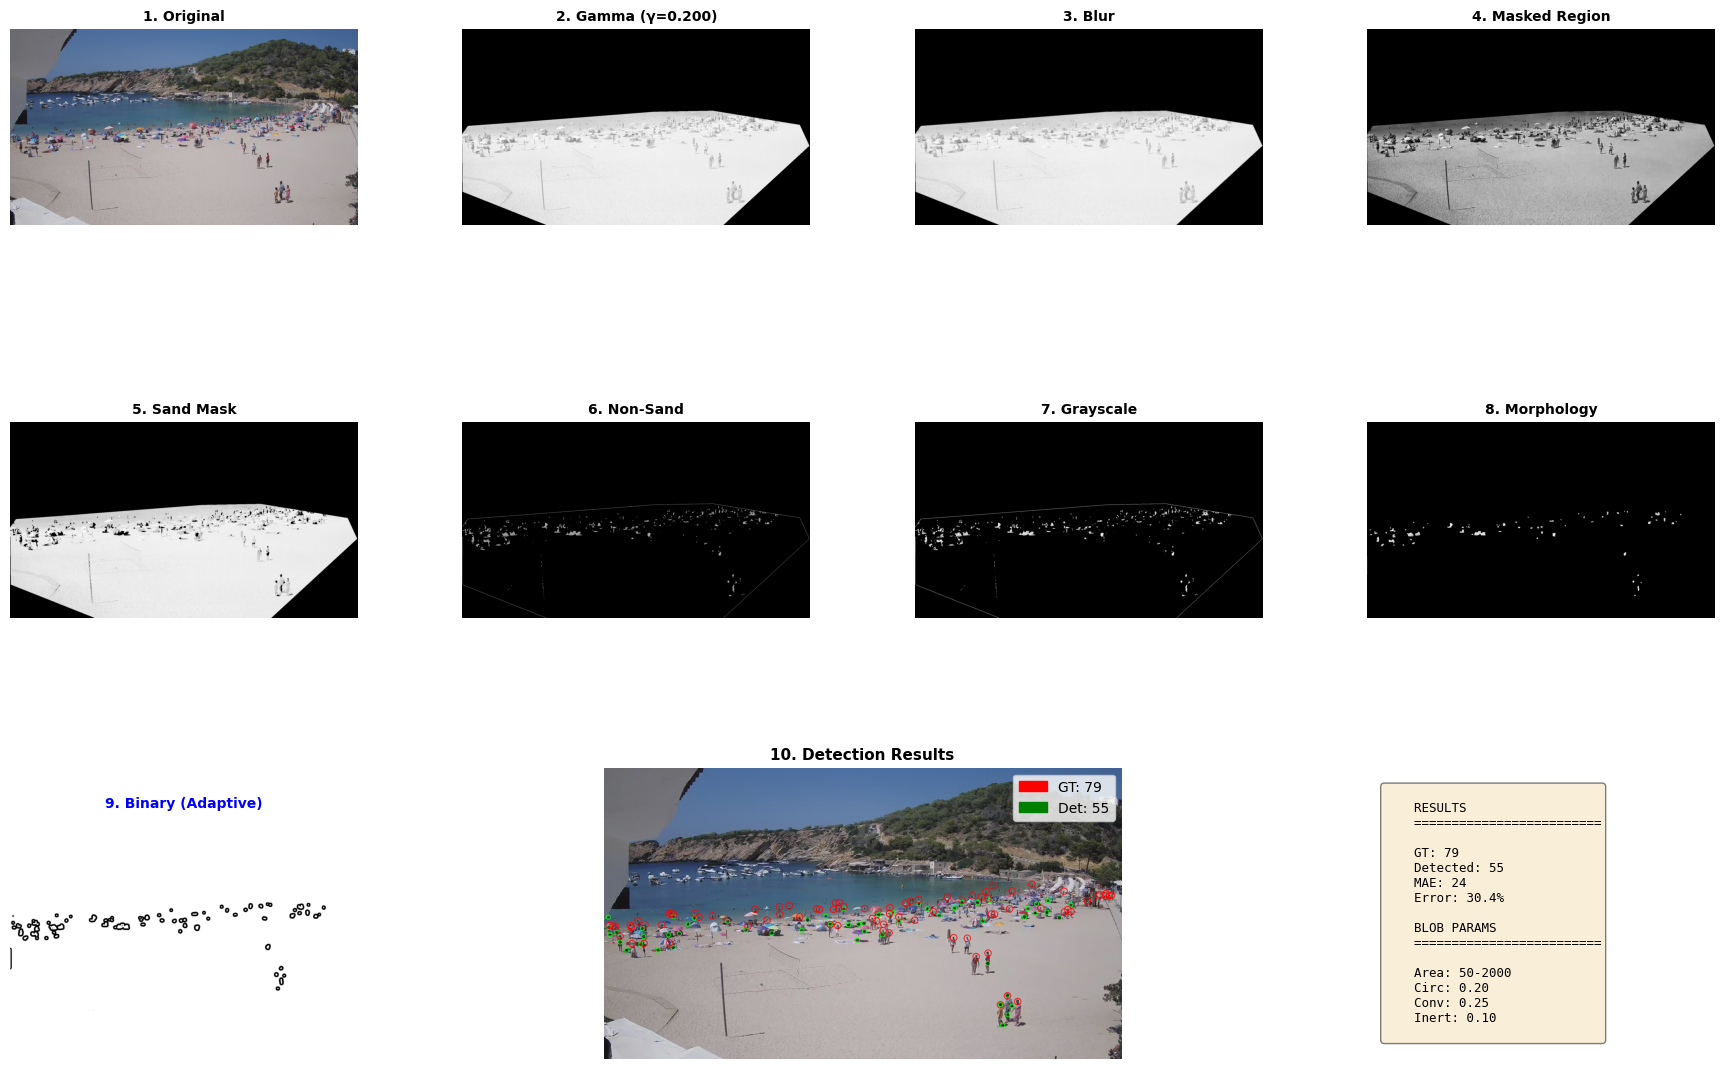


=== Processing: 1660316400.jpg ===


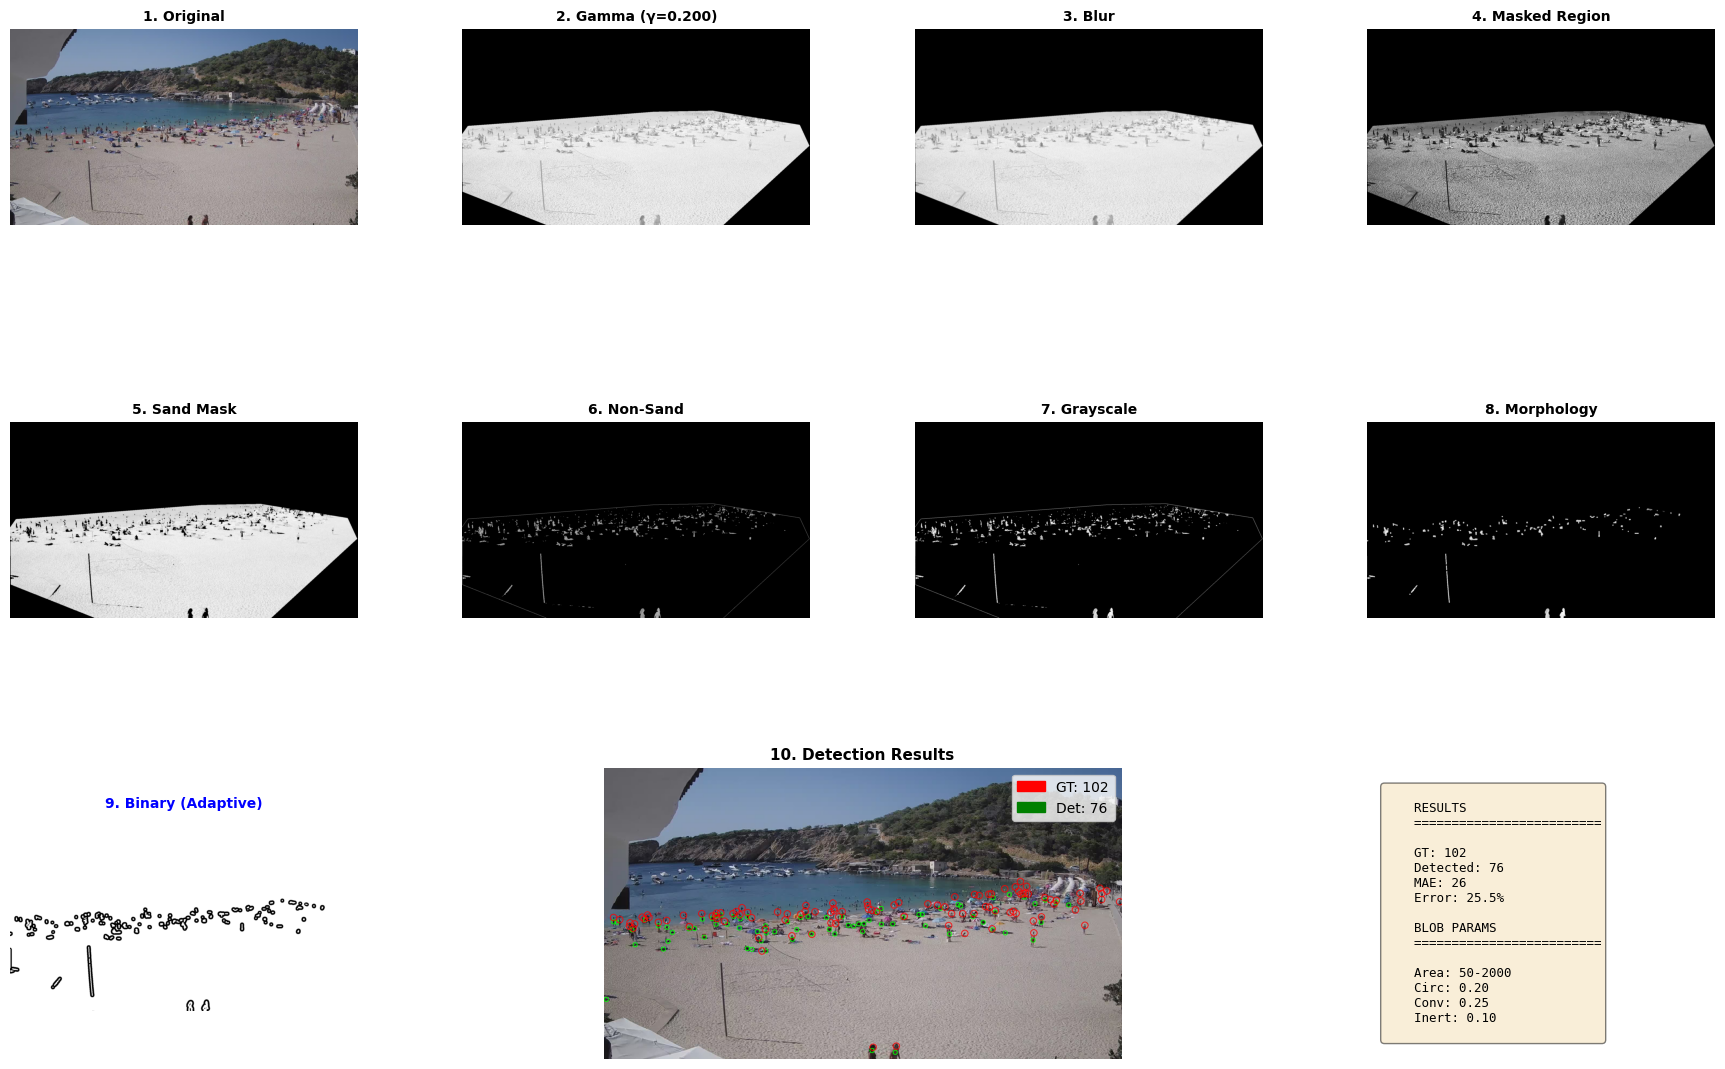


=== Processing: 1660320000.jpg ===


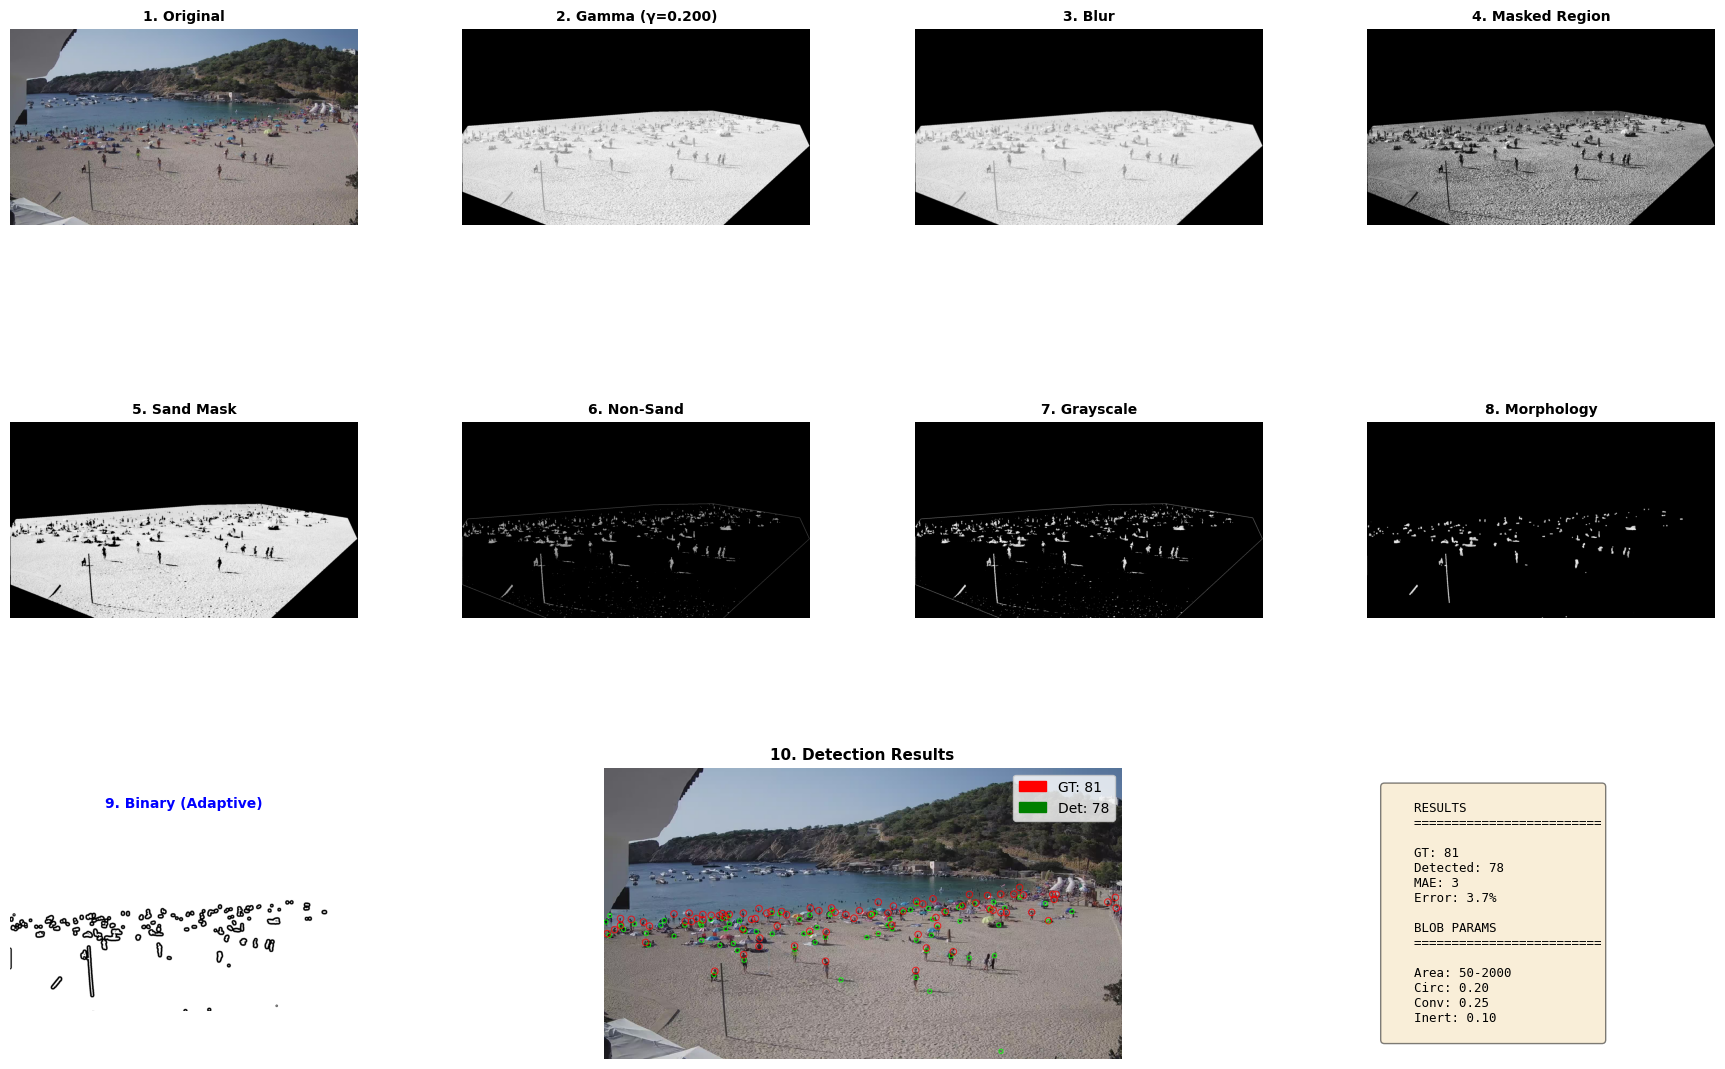

In [10]:
# Process all images with current parameters from the interactive UI
p = unified_interface.kwargs  
results = []

for img_file in image_files:
    print(f"\n=== Processing: {img_file} ===")
    res = comprehensive_analysis(
        img_file,
        target_brightness=p["target_brightness"] if "target_brightness" in p else 160.0,
        clahe_clip=p["clahe_clip"],
        gaussian_size=int(p["gaussian_size"]),
        adaptive_block_size=int(p["adaptive_block_size"]),
        adaptive_c=p["adaptive_c"],
        top_mask_percent=p["top_mask_percent"],
        hsv_s_max=p["hsv_s_max"],
        hsv_v_min=p["hsv_v_min"],
        morph_size=int(p["morph_size"]),
        min_area=int(p["min_area"]),
        max_area=int(p["max_area"]),
        min_circularity=p["min_circularity"],
        min_convexity=p["min_convexity"],
        min_inertia=p["min_inertia"],
        clear=False,
    )
    results.append(res)

# Final report
if results:
    maes = np.array([r["mae"] for r in results], dtype=float)
    sq_errors = np.array([r["squared_error"] for r in results], dtype=float)
    error_percents = np.array([r["error_percent"] for r in results], dtype=float)

    display(HTML(f"""
    <div style="background-color:#34495e; color:black; padding:20px; border-radius:10px; margin-top:25px;">
        <h2 style="margin-top:0;">📑 Global Validation Report</h2>
        <table style="width:100%; color:black;">
            <tr><td><b>Images evaluated:</b></td><td>{len(results)}</td></tr>
            <tr><td><b>Mean MAE:</b></td><td>{maes.mean():.3f}</td></tr>
            <tr><td><b>Mean Squared Error:</b></td><td>{sq_errors.mean():.3f}</td></tr>
            <tr><td><b>Mean error percentage:</b></td><td>{error_percents.mean():.2f}%</td></tr>
        </table>
    </div>
    """))
else:
    print("No results to summarize.")

generate_results_figures(results):